# _**Create the grid for WHETGEO 1D ADE coupled with shallow water**_
    -Author: Concetta D'Amato, Niccolò Tubini and Riccardo Rigon
    -License: this work is licensed under a Creative Commons Attribution-NonCommercial 4.0 International License
-----
This code allows to create a mesh for 1D PDE problem:
    - domain discretization
    - setting parameters
    - setting initial condition
    
All output data are stored in a NetCDF file.
This file is one of the input file of your simulation.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.style as style 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import matplotlib.style as style 
import xarray as xr
import datetime

from WHETGEO1D_GridCreator import*
from WHETGEO1D_toNetCDF import*

import warnings
warnings.filterwarnings('ignore')
####### Plot settings #######
nice_fonts = {
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.facecolor": "white",
        "axes.edgecolor": "0.8",
        "axes.linewidth": 0.6,
        "grid.linewidth":0.3,
        # Use LaTeX to write all text
        "text.usetex": False,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 16,
        "font.size": 16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
}
plt.rcParams.update(nice_fonts)

project_path = os.path.dirname(os.getcwd())


## Define input:
**grid_input_file_name**: name of the grid input file (.csv) with the local file path 
   
> `/data/Grid_input/name.csv`

**ic_input_file_name**: name of the initial condition input file (.csv) with the local file path 
> `/data/Grid_input/name.csv`

**icRoot_input_file_name**: name of the  initial condition input file (.csv) with the local file path 
> `/data/Grid_input/name.csv`

**parameter_input_file_name**: name of the parameter input file (.csv) with the local file path 
>`/data/Grid_input/name.csv`

**dictionary_input_file_name**: name of the file (.csv) containing the dictionary for parameters name 
>`/data/Grid_input/name.csv`

**grid_type**: string defining how to discretize the 1D domain. You can choose among:
> `classical`

> `exponential`

> `mixed` 


**dz_min**: thickness of the first layer (for `exponential` and `mixed`)

**dz_max**: larger thickness of the grid (for `mixed`)

**b**: growth rate (for `exponential` and `mixed`)

**psi_interp_model**: string defining the type of the 1D interpolation function used to define the initial condition for water suction \[m\]
> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d 

**T_interp_model**: string defining the type of the 1D interpolation function used to define the initial condition for temperature \[K\]
>https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d 

**root_interp_model**: string defining the type of the 1D interpolation function used to define the initial condition for root density \\
> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

**water_ponding_0**: surface water ponding \[m\] at time $t=0$

**T_water_ponding_0**: temperature \[K\] of surface water ponding at time $t=0$

**etaR**: root depth  

<br />


**output_file_name**: name of the output file (.nc) with the local file path
>`/data/Grid_NetCDF/name.nc`

**output_title**: string containing a title for the output, it is saved within the file

**output_summary**: string containing a description for the output, it is saved within the file (global metadata)

**output_date**: string containing the date of file creation, optionally

**output_institution**: string containing the name of whom created the file, optionally



In [2]:
grid_input_file_name = project_path + "/data/Grid_input/_grid_Richards_Solute_coupled.csv"

ic_input_file_name = project_path + "/data/Grid_input/_ic_Solute.csv"

icRoot_input_file_name = project_path + "/data/Grid_input/icRoot_230222.csv"

parameter_input_file_name = project_path + "/data/Grid_input/parameter_geospace.csv"

dictionary_input_file_name = project_path + "/data/Grid_input/dictionary.csv"


grid_type =   'classical' #'classical' 'exponential' 'mixed'

dz_min = 0.005
dz_max = 0.1
b = 0.1

psi_interp_model = "linear"
T_interp_model = "linear"
root_interp_model = "linear"

etaR = -0.7

water_ponding_0 = -0.5
T_water_ponding_0 = 293.15


output_file_name =   project_path + "/data/Grid_NetCDF/Grid_Richards_Solute_1904.nc"
output_title = '''     '''
output_summary = '''    '''

output_date = ''
output_institution = ''

## Run

In [3]:
data_grid = pd.read_csv(grid_input_file_name)
print(data_grid)

data_ic = pd.read_csv(ic_input_file_name)
print(data_ic)

data_icRoot = pd.read_csv(icRoot_input_file_name)
print(data_icRoot)

data_parameter = pd.read_csv(parameter_input_file_name, comment='#')
print()
print(data_parameter)

data_dictionary = pd.read_csv(dictionary_input_file_name)

[KMAX, eta, eta_dual, space_delta, z, z_dual, control_volume]=grid1D(data_grid, dz_min, b, dz_max, grid_type, shallow_water=True)

[psi_0, T_0, root_0] = set_initial_condition_lysimeter(data_ic, data_icRoot, eta, psi_interp_model, T_interp_model, root_interp_model, etaR, water_ponding_0=water_ponding_0, T_water_ponding_0=T_water_ponding_0, shallow_water=True, fill_value="extrapolate")

control_volume_index = calibration_point_index(data_grid, eta)

[equation_state_ID, parameter_ID, theta_s, theta_r, theta_wp, theta_fc, par_1, par_2, par_3, par_4,
par_5, alpha_ss, beta_ss, ks] = set_parameters_richards_lysimeter(data_grid, data_parameter, data_dictionary, KMAX, eta)

write_grid_netCDF_richards_lysimeter(eta, eta_dual, z, z_dual, space_delta, control_volume, control_volume_index, psi_0, T_0, root_0, equation_state_ID, parameter_ID, KMAX,
                  theta_s, theta_r, theta_wp, theta_fc, par_1, par_2, par_3, par_4, par_5, alpha_ss, beta_ss, ks,
                  output_file_name, output_title, output_institution, output_summary, output_date, grid_input_file_name, parameter_input_file_name)

  Type  eta    K  equationStateID  parameterID
0    L  0.0  5.0              1.0          2.0
1    L -0.5  NaN              NaN          NaN
   eta  Psi0      T0
0 -0.0  -0.5  273.15
1 -0.5   0.0  273.15
   eta  Root0
0 -0.0      1
1 -0.7      0

    thetaS   thetaR  thetaWP  thetaFC        n  alpha  alphaSpecificStorage  \
0  0.36689  0.05385  0.08385  0.33689  2.54723  2.991                   0.0   
1  0.48664  0.13335  0.16335  0.45664  1.34174  0.846                   0.0   
2  0.46000  0.07000  0.09700  0.43200  1.65000  0.440                   0.0   
3  0.41000  0.06500  0.06600  0.38000  1.89000  7.500                   0.0   

   betaSpecificStorage            Ks  
0                  0.0  5.405830e-05  
1                  0.0  9.732840e-07  
2                  0.0  5.173635e-06  
3                  0.0  1.227800e-05  


***SUCCESS writing!  /Users/concettadamato/Eclipse_workspace_12/WHETGEO-1D/data/Grid_NetCDF/Grid_Richards_Solute_1904.nc


In [4]:
#help(set_parameters_richards_lysimeter)

## Show Root geometry

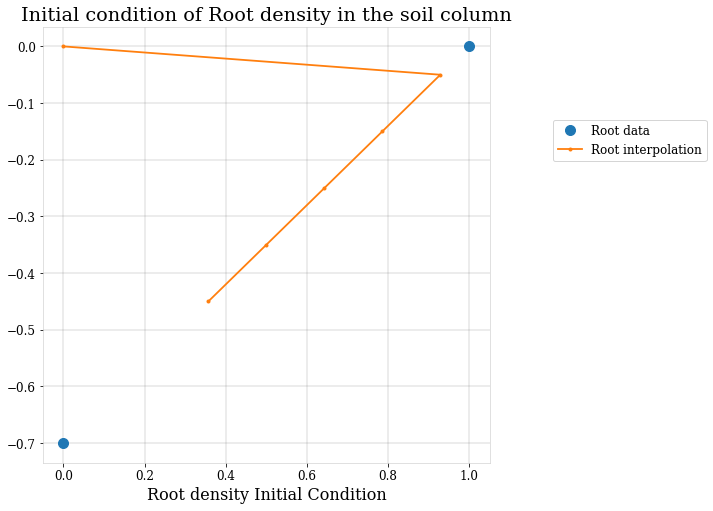

In [5]:
fig = plt.figure(figsize=(8,13/1.62))
plt.plot(data_icRoot.Root0,data_icRoot.eta, '.',label = 'Root data',markersize=20)
plt.plot(root_0, eta, '.-', label='Root interpolation',linewidth=1.8)
plt.xlabel('Root density Initial Condition')
plt.title('Initial condition of Root density in the soil column')
plt.legend(bbox_to_anchor=(1.5,0.8))
plt.grid(color='grey', linestyle='-', linewidth=0.3)

## Show Grid geometry

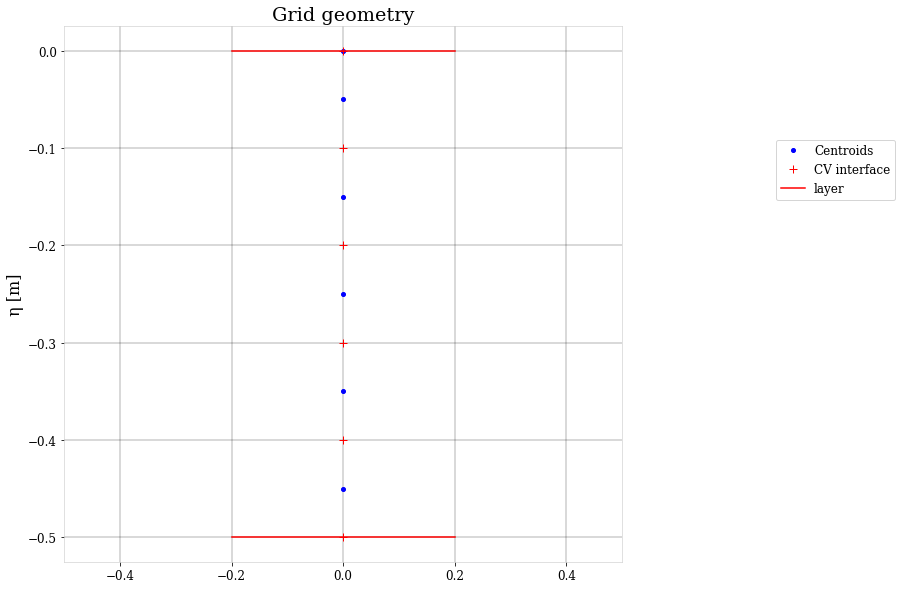

In [6]:
showMesh(data_grid)